In [195]:
import pandas as pd
import talib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [196]:
input_data = pd.read_csv("INFY-EQ-24-02-2024-to-24-02-2025.csv", encoding="utf-8")
input_data.rename(columns=lambda x: x.strip(), inplace=True)

if 'Date' not in input_data.columns:
    raise KeyError("The 'Date' column is missing. Check column names in the CSV.")

input_data["Date"] = pd.to_datetime(input_data["Date"].astype(str).str.strip(), format="%d-%b-%y", errors='coerce')
input_data = input_data.dropna(subset=["Date"])
input_data = input_data.sort_values(by="Date")

input_data["Close"] = input_data["Close"].astype(str).str.replace(",", "").astype(float)
input_data = input_data.reset_index(drop=True)

print("Checking 2024-09-11:")
print(input_data[input_data["Date"] == pd.Timestamp("2024-09-11")][["Date", "Close"]])

close_price_data = input_data["Close"].values

input_data["SMA_10"] = talib.SMA(close_price_data, timeperiod=10)
input_data["EMA_50"] = talib.EMA(close_price_data, timeperiod=50)
input_data["RSI_14"] = talib.RSI(close_price_data, timeperiod = 14)
macd, macdsignal, macdhist = talib.MACD(close_price_data, fastperiod=12, slowperiod=26, signalperiod=9)
input_data["MACD"] = macd
input_data["MACD_SIGNAL"] = macdsignal
input_data["MACD_HIST"] = macdhist

latest_ema = input_data["EMA_50"].dropna()
latest_sma = input_data["SMA_10"].dropna()
latest_rsi = input_data["RSI_14"].dropna()
latest_macd = input_data["MACD"].dropna()
latest_macdsignal = input_data["MACD_SIGNAL"].dropna()
latest_macdhist = input_data["MACD_HIST"].dropna()

latest_close_price = input_data["Close"].iloc[-1]

input_data.to_csv("EMA_50_Values.csv", index=False)
input_data.to_csv("SMA_10_Values.csv", index=False)
input_data.to_csv("RSI_14_Values.csv", index = False)
input_data.to_csv("MACD_Values.csv", index=False)

print("Current Price:", latest_close_price)
print("Close_price_Length:", len(close_price_data))
print("Latest EMA Length:", len(latest_ema))
print("Latest SMA Length:", len(latest_sma))
print("Latest RSI Length:", len(latest_rsi))
print("MACD Values Length:", len(latest_macd))
print("MACD Signals Length:", len(latest_macdsignal))
print("MACD Hist Length:", len(latest_macdhist))


Checking 2024-09-11:
          Date    Close
134 2024-09-11  1910.15
Current Price: 1815.0
Close_price_Length: 249
Latest EMA Length: 200
Latest SMA Length: 240
Latest RSI Length: 235
MACD Values Length: 216
MACD Signals Length: 216
MACD Hist Length: 216


In [197]:
def find_swing_points(data, window=5, tolerance=0.5):
    
    support_levels = []
    resistance_levels = []
    support_to_resistance = []
    resistance_to_support = []
    
    for i in range(window, len(data) - window):
        current_price = data["Close"].iloc[i]
        window_before = data["Close"].iloc[i - window:i]
        window_after = data["Close"].iloc[i + 1:i + window + 1]

        if current_price < min(window_before) and current_price < min(window_after):
            support_levels.append((data["Date"].iloc[i], current_price))
            
        if current_price > max(window_before) and current_price > max(window_after):
            resistance_levels.append((data["Date"].iloc[i], current_price))

    all_levels = support_levels + resistance_levels
    all_levels.sort(key=lambda x: x[0]) 
    
    final_support_levels = []
    final_resistance_levels = []
    
    for i in range(len(data)):
        current_price = data["Close"].iloc[i]
        current_date = data["Date"].iloc[i]
        
        for level_date, level_price in all_levels:
            price_diff = abs(current_price - level_price)
            tolerance_range = level_price * (tolerance / 100)
            
            if price_diff <= tolerance_range and level_date < current_date:
                if (level_date, level_price) in support_levels:
                    if current_price <= level_price:
                        support_to_resistance.append((current_date, current_price))
                        final_resistance_levels.append((current_date, current_price))
                
                elif (level_date, level_price) in resistance_levels:
                    if current_price >= level_price:
                        resistance_to_support.append((current_date, current_price))
                        final_support_levels.append((current_date, current_price))
                        
    final_support_levels = list(set(support_levels + resistance_to_support))
    final_resistance_levels = list(set(resistance_levels + support_to_resistance))
    final_support_levels.sort(key=lambda x: x[0])
    final_resistance_levels.sort(key=lambda x: x[0])
    
    return {
        'initial_support': support_levels,
        'initial_resistance': resistance_levels,
        'support_to_resistance': support_to_resistance,
        'resistance_to_support': resistance_to_support,
        'final_support': final_support_levels,
        'final_resistance': final_resistance_levels
    }

levels = find_swing_points(input_data, window=5, tolerance=0.5)
 
print("\n Initial Support Levels:", len(levels['initial_support']))
for date, price in levels['initial_support']:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price: {price}")

print("\n Initial Resistance Levels:", len(levels['initial_resistance']))
for date, price in levels['initial_resistance']:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price: {price}")

print("\n Support Levels Converted to Resistance:", len(levels['support_to_resistance']))
for date, price in levels['support_to_resistance']:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price: {price}")

print("\n Resistance Levels Converted to Support:", len(levels['resistance_to_support']))
for date, price in levels['resistance_to_support']:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price: {price}")

print("\n Final Support Levels:", len(levels['final_support']))
for date, price in levels['final_support']:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price: {price}")

print("\n Final Resistance Levels:", len(levels['final_resistance']))
for date, price in levels['final_resistance']:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price: {price}")



 Initial Support Levels: 14
Date: 2024-03-11, Price: 1600.6
Date: 2024-04-19, Price: 1411.25
Date: 2024-05-02, Price: 1414.45
Date: 2024-05-15, Price: 1419.95
Date: 2024-06-04, Price: 1393.65
Date: 2024-08-08, Price: 1743.15
Date: 2024-09-09, Price: 1894.65
Date: 2024-09-18, Price: 1892.15
Date: 2024-09-30, Price: 1875.6
Date: 2024-11-05, Price: 1754.2
Date: 2024-11-18, Price: 1811.45
Date: 2024-12-31, Price: 1880.0
Date: 2025-01-09, Price: 1917.3
Date: 2025-01-21, Price: 1800.7

 Initial Resistance Levels: 15
Date: 2024-03-14, Price: 1653.3
Date: 2024-04-10, Price: 1506.8
Date: 2024-05-07, Price: 1440.95
Date: 2024-05-23, Price: 1472.4
Date: 2024-06-07, Price: 1533.6
Date: 2024-07-26, Price: 1878.9
Date: 2024-09-02, Price: 1964.5
Date: 2024-09-17, Price: 1952.55
Date: 2024-10-17, Price: 1968.1
Date: 2024-11-12, Price: 1868.8
Date: 2024-11-27, Price: 1924.5
Date: 2024-12-13, Price: 1999.7
Date: 2025-01-02, Price: 1957.85
Date: 2025-01-10, Price: 1966.95
Date: 2025-02-06, Price: 1915.6

In [198]:
def detect_trend_extended(levels, threshold=2):
   
    trend_analysis = []
    prev_high, prev_low = None, None

    uptrend_values = []
    downtrend_values = []
    sideways_values = []

    for date, price in levels['final_support']:
        if prev_low is not None and price > prev_low:
            trend_analysis.append((date, price, "Higher Low (Uptrend)"))
            uptrend_values.append((date, price))
        prev_low = price

    for date, price in levels['final_resistance']:
        if prev_high is not None and price > prev_high:
            trend_analysis.append((date, price, "Higher High (Uptrend)"))
            uptrend_values.append((date, price))
        prev_high = price

    prev_high, prev_low = None, None
    for date, price in levels['final_support']:
        if prev_low is not None and price < prev_low:
            trend_analysis.append((date, price, "Lower Low (Downtrend)"))
            downtrend_values.append((date, price))
        prev_low = price

    for date, price in levels['final_resistance']:
        if prev_high is not None and price < prev_high:
            trend_analysis.append((date, price, "Lower High (Downtrend)"))
            downtrend_values.append((date, price))
        prev_high = price

    for i in range(1, len(levels['final_support'])):
        date1, price1 = levels['final_support'][i - 1]
        date2, price2 = levels['final_support'][i]

        percentage_change = abs(price2 - price1) / price1 * 100
        if percentage_change < threshold:
            trend_analysis.append((date2, price2, "Sideways Trend"))
            sideways_values.append((date2, price2))

    return {
        'trend_analysis': trend_analysis,
        'uptrend': uptrend_values,
        'downtrend': downtrend_values,
        'sideways': sideways_values
    }
    
trend_data = detect_trend_extended(levels)

print("\n Uptrend:")
for date, price in trend_data['uptrend']:
    print(f"Date: {date}, Price: {price}, Type: Uptrend")

print("\n Downtrend:")
for date, price in trend_data['downtrend']:
    print(f"Date: {date}, Price: {price}, Type: Downtrend")

print("\n Sideways Trend:")
for date, price in trend_data['sideways']:
    print(f"Date: {date}, Price: {price}, Type: Sideways Trend")



 Uptrend:
Date: 2024-05-02 00:00:00, Price: 1414.45, Type: Uptrend
Date: 2024-05-15 00:00:00, Price: 1419.95, Type: Uptrend
Date: 2024-05-17 00:00:00, Price: 1444.3, Type: Uptrend
Date: 2024-06-19 00:00:00, Price: 1511.35, Type: Uptrend
Date: 2024-06-26 00:00:00, Price: 1540.7, Type: Uptrend
Date: 2024-07-09 00:00:00, Price: 1657.15, Type: Uptrend
Date: 2024-08-08 00:00:00, Price: 1743.15, Type: Uptrend
Date: 2024-08-22 00:00:00, Price: 1880.25, Type: Uptrend
Date: 2024-09-09 00:00:00, Price: 1894.65, Type: Uptrend
Date: 2024-10-09 00:00:00, Price: 1952.75, Type: Uptrend
Date: 2024-10-14 00:00:00, Price: 1958.9, Type: Uptrend
Date: 2024-10-15 00:00:00, Price: 1959.3, Type: Uptrend
Date: 2024-10-17 00:00:00, Price: 1968.1, Type: Uptrend
Date: 2024-11-18 00:00:00, Price: 1811.45, Type: Uptrend
Date: 2024-12-02 00:00:00, Price: 1879.8, Type: Uptrend
Date: 2024-12-11 00:00:00, Price: 1974.15, Type: Uptrend
Date: 2024-12-17 00:00:00, Price: 1976.6, Type: Uptrend
Date: 2025-01-01 00:00:00, 

In [199]:
def calculate_trend_differences(levels):
    uptrend_differences = []  
    downtrend_differences = []  
    sidetrend_differences = []  

    prev_support = None
    prev_resistance = None

    for date, price in levels['final_support']:
        if prev_support is not None and price > prev_support:
            uptrend_differences.append((date, price - prev_support)) 
        prev_support = price

    for date, price in levels['final_resistance']:
        if prev_resistance is not None and price < prev_resistance:
            downtrend_differences.append((date, prev_resistance - price))  
        prev_resistance = price

    for i in range(1, len(levels['final_support'])):
        date1, price1 = levels['final_support'][i - 1]
        date2, price2 = levels['final_support'][i]

        if abs(price2 - price1) / price1 < 0.02: 
            sidetrend_differences.append((date2, abs(price2 - price1))) 

    return uptrend_differences, downtrend_differences, sidetrend_differences

uptrend_diff, downtrend_diff, sidetrend_diff = calculate_trend_differences(levels)


print("\nUptrend Price Differences:")
for date, diff in uptrend_diff:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price Difference: {diff}")

print("\nDowntrend Price Differences:")
for date, diff in downtrend_diff:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price Difference: {diff}")

print("\nSideways Trend Price Differences:")
for date, diff in sidetrend_diff:
    print(f"Date: {date.strftime('%Y-%m-%d')}, Price Difference: {diff}")


Uptrend Price Differences:
Date: 2024-05-02, Price Difference: 3.2000000000000455
Date: 2024-05-15, Price Difference: 5.5
Date: 2024-05-17, Price Difference: 24.34999999999991
Date: 2024-06-19, Price Difference: 117.69999999999982
Date: 2024-06-26, Price Difference: 29.350000000000136
Date: 2024-07-09, Price Difference: 116.45000000000005
Date: 2024-08-08, Price Difference: 86.0
Date: 2024-08-22, Price Difference: 137.0999999999999
Date: 2024-09-09, Price Difference: 14.400000000000091
Date: 2024-10-09, Price Difference: 77.15000000000009
Date: 2024-10-14, Price Difference: 6.150000000000091
Date: 2024-10-15, Price Difference: 0.3999999999998636
Date: 2024-10-17, Price Difference: 8.799999999999955
Date: 2024-11-18, Price Difference: 57.25
Date: 2024-12-02, Price Difference: 68.34999999999991
Date: 2024-12-11, Price Difference: 94.35000000000014
Date: 2024-12-17, Price Difference: 2.449999999999818
Date: 2025-01-01, Price Difference: 2.5
Date: 2025-01-02, Price Difference: 75.34999999

In [200]:
def detect_breakouts(data, levels):
    breakouts = []
    breakdowns = []

    for i in range(1, len(data)):
        current_price = data["Close"].iloc[i]
        prev_price = data["Close"].iloc[i-1]
        current_date = data["Date"].iloc[i]

        for date, level in levels['final_resistance']:
            if prev_price < level and current_price > level:
                breakouts.append((current_date, level, "Resistance Breakout"))

        for date, level in levels['final_support']:
            if prev_price > level and current_price < level:
                breakdowns.append((current_date, level, "Support Breakdown"))

    return breakouts, breakdowns

breakouts, breakdowns = detect_breakouts(input_data, levels)

print("\nBreakouts:")
for date, level, msg in breakouts:
    print(f"Date: {date}, Level: {level}, {msg}")

print("\nBreakdowns:")
for date, level, msg in breakdowns:
    print(f"Date: {date}, Level: {level}, {msg}")



Breakouts:
Date: 2024-04-23 00:00:00, Level: 1440.95, Resistance Breakout
Date: 2024-05-16 00:00:00, Level: 1440.95, Resistance Breakout
Date: 2024-05-22 00:00:00, Level: 1440.95, Resistance Breakout
Date: 2024-06-05 00:00:00, Level: 1406.9, Resistance Breakout
Date: 2024-06-05 00:00:00, Level: 1405.9, Resistance Breakout
Date: 2024-06-06 00:00:00, Level: 1440.95, Resistance Breakout
Date: 2024-06-07 00:00:00, Level: 1506.8, Resistance Breakout
Date: 2024-06-07 00:00:00, Level: 1472.4, Resistance Breakout
Date: 2024-06-19 00:00:00, Level: 1506.8, Resistance Breakout
Date: 2024-06-25 00:00:00, Level: 1533.6, Resistance Breakout
Date: 2024-07-08 00:00:00, Level: 1653.3, Resistance Breakout
Date: 2024-07-12 00:00:00, Level: 1653.3, Resistance Breakout
Date: 2024-07-22 00:00:00, Level: 1810.8, Resistance Breakout
Date: 2024-07-26 00:00:00, Level: 1873.4, Resistance Breakout
Date: 2024-07-26 00:00:00, Level: 1868.8, Resistance Breakout
Date: 2024-07-26 00:00:00, Level: 1868.4, Resistance B

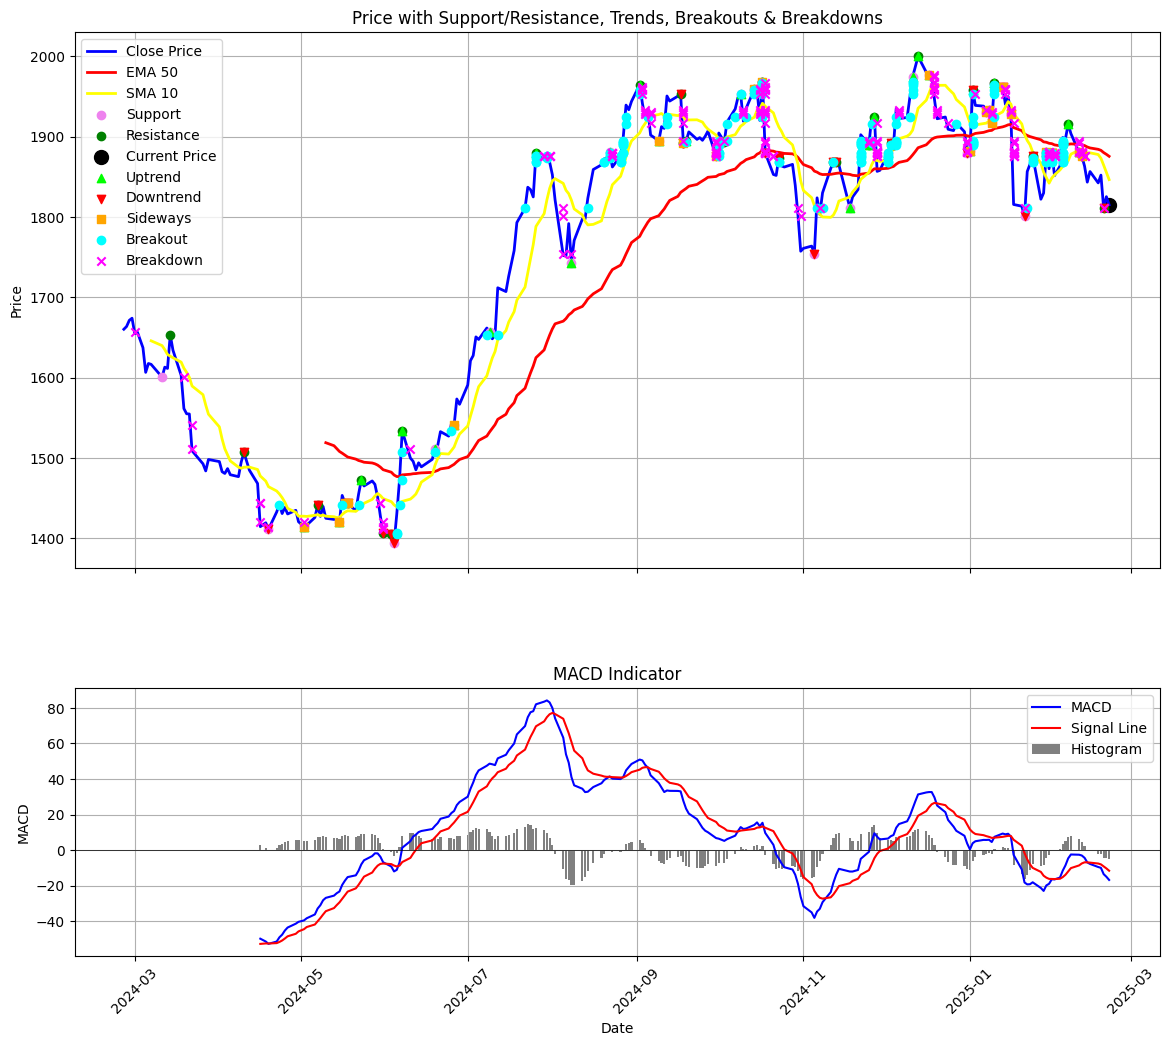

In [201]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), height_ratios=[2, 1], sharex=True)

ax1.plot(input_data["Date"], input_data["Close"], label="Close Price", color="blue", linewidth=2)
ax1.plot(input_data["Date"], input_data["EMA_50"], label="EMA 50", color="red", linewidth=2)
ax1.plot(input_data["Date"], input_data["SMA_10"], label="SMA 10", color="yellow", linewidth=2)

if levels["final_support"]:
    support_dates, support_prices = zip(*levels['final_support'])
    ax1.scatter(support_dates, support_prices, color='violet', label='Support', zorder=5)
if levels["final_resistance"]:
    resistance_dates, resistance_prices = zip(*levels['final_resistance'])
    ax1.scatter(resistance_dates, resistance_prices, color='green', label='Resistance', zorder=5)

ax1.scatter(input_data["Date"].iloc[-1], input_data["Close"].iloc[-1], label="Current Price", color="black", s=100)

uptrend_added = downtrend_added = sideways_added = False

for date, price, trend_type in trend_data['trend_analysis']:
    if "Uptrend" in trend_type:
        ax1.scatter(date, price, color='lime', marker='^', zorder=5, 
                    label="Uptrend" if not uptrend_added else None)
        uptrend_added = True
    elif "Downtrend" in trend_type:
        ax1.scatter(date, price, color='red', marker='v', zorder=5, 
                    label="Downtrend" if not downtrend_added else None)
        downtrend_added = True
    elif "Sideways" in trend_type:
        ax1.scatter(date, price, color='orange', marker='s', zorder=5, 
                    label="Sideways" if not sideways_added else None)
        sideways_added = True

breakout_added = breakdown_added = False

for date, level, _ in breakouts:
    ax1.scatter(date, level, color='cyan', marker='o', zorder=6, 
                label="Breakout" if not breakout_added else None)
    breakout_added = True
for date, level, _ in breakdowns:
    ax1.scatter(date, level, color='magenta', marker='x', zorder=6, 
                label="Breakdown" if not breakdown_added else None)
    breakdown_added = True

ax1.set_ylabel("Price")
ax1.set_title("Infosys Price with Support/Resistance, Trends, Breakouts & Breakdowns")
ax1.legend()
ax1.grid()

ax2.plot(input_data["Date"], input_data["MACD"], label="MACD", color="blue", linewidth=1.5)
ax2.plot(input_data["Date"], input_data["MACD_SIGNAL"], label="Signal Line", color="red", linewidth=1.5)
ax2.bar(input_data["Date"], input_data["MACD_HIST"], label="Histogram", color="gray", alpha=1)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_xlabel("Date")
ax2.set_ylabel("MACD")
ax2.set_title("MACD Indicator")
ax2.legend()
ax2.grid()

ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

plt.subplots_adjust(hspace=0.3) 

plt.show()
